# JupyterCon 2018 Globus + JupyterHub Tutorial
----

This tutorial shows you how to pull Globus Auth tokens from the Jupyter Notebook Server environment and use them to interact with different REST APIs secured with Globus Auth. Our code here is pedantic, for clarity; much could be encapsulated in Python packages to simplify the notebook.

N.B. Tokens are issued and stored in the JupyterHub database at login. They typically expire in 24 hours and without a mechanism to handle refresh tokens or to retrieve new ones the simplest way to get new ones is to:

1. Stop your server (see the Control Panel)
1. Log out
1. Log back in
1. Start your server
1. Launch the notebook


Note: You need to join the tutorial group at https://www.globus.org/app/groups/50b6a29c-63ac-11e4-8062-22000ab68755/about to be able to access the shared endpoint at the end.

## Import Packages

In [30]:
# These are to get the tokens
import os
import pickle
import base64

# Much of what we're dealing with is JSON
import json

# We're going to be making explicit HTTPS calls
import requests

# This is to work with data for our example
import csv
import datetime
import matplotlib.pyplot as plt
from io import StringIO

## Get Tokens

The tokens are passed into the environment `base64` encoded as a pickled Python dictionary assigned to the `GLOBUS_DATA` variable. We'll grab the variable and unpack it. 

In [31]:
# Get the content
globus_env_data = os.getenv('GLOBUS_DATA')

In [32]:
# Now we have the pickled tokens
pickled_tokens = base64.b64decode(globus_env_data)

# Unpickle and get the dictionary
tokens = pickle.loads(pickled_tokens)

# Minimal sanity check, did we get the data type we expected?
isinstance(tokens, dict)

True

## Look Inside the Tokens

Depending on the JupyterHub configuration, there will be different numbers of tokens. For this tutorial, our identity token is a __[JSON Web Token (JWT)](https://tools.ietf.org/html/rfc7519)__, and we access tokens for different Resource Servers and scopes, like getting our profile from Globus Auth.

In [19]:
print(json.dumps(tokens, indent=4, sort_keys=True))

{
    "client_id": "f3a687a3-ebdc-4ed6-af5b-c16a2d2a3fd9",
    "id_token": {
        "at_hash": "HW_k9Az0X1qtYuWLBQvmr2G_fEgXXuEdhoAA1dcdIhg",
        "aud": "f3a687a3-ebdc-4ed6-af5b-c16a2d2a3fd9",
        "email": "ianfost@gmail.com",
        "exp": 1534952960,
        "iat": 1534780160,
        "identity_provider": "41143743-f3c8-4d60-bbdb-eeecaba85bd9",
        "identity_provider_display_name": "Globus ID",
        "iss": "https://auth.globus.org",
        "name": "Ian Foster",
        "organization": "Argonne National Laboratory",
        "preferred_username": "ian@globusid.org",
        "sub": "aea41e74-d274-11e5-b9f5-5b565b3d3da2"
    },
    "tokens": {
        "auth.globus.org": {
            "access_token": "Agk1KmOMnKNE64aXNQJwq9Mk84yJVBay1a0xPm3r4gJkpbxq1giOCxNEw64brvyj81b1k4NvedGGejCjgwaGocXb1OUOMNmiN24Q",
            "expires_at_seconds": 1534952961,
            "refresh_token": null,
            "scope": "profile openid email",
            "token_type": "Bearer"
        },

## Using the Tokens

Now we can get started talking to different servers. In this tutorial, we show how tokens can be passed as HTTP headers. Much of this can also be done with the __[Globus Python SDK](http://globus-sdk-python.readthedocs.io/en/stable/)__.

### User Info

First, let's use our `auth.globus.org` token to get our __[OAuth2 user information](https://docs.globus.org/api/auth/reference/#get_or_post_v2_oauth2_userinfo_resource)__. We assemble the header with the appropriate access token and do an HTTP `GET` on the resource.

In [20]:
# Create the header
headers = {'Authorization':'Bearer '+ tokens['tokens']['auth.globus.org']['access_token']}

# Get the user info as JSON
user_info = requests.get('https://auth.globus.org/v2/oauth2/userinfo',headers=headers).json()

# Look at the response
print(json.dumps(user_info, indent=4, sort_keys=True))

{
    "email": "ianfost@gmail.com",
    "identity_provider": "41143743-f3c8-4d60-bbdb-eeecaba85bd9",
    "identity_provider_display_name": "Globus ID",
    "name": "Ian Foster",
    "organization": "Argonne National Laboratory",
    "preferred_username": "ian@globusid.org",
    "sub": "aea41e74-d274-11e5-b9f5-5b565b3d3da2"
}


### Identities

This is the __[Globus Auth API resource for identities](https://docs.globus.org/api/auth/reference/#v2_api_identities_resources)__. We use a similar process, but we're doing a `GET` on a specific identity, our own.

In [6]:
identity = requests.get('https://auth.globus.org/v2/api/identities/' + user_info['sub'],headers=headers).json()
print(json.dumps(identity, indent=4, sort_keys=True))

{
    "identity": {
        "email": "ianfost@gmail.com",
        "id": "aea41e74-d274-11e5-b9f5-5b565b3d3da2",
        "identity_provider": "41143743-f3c8-4d60-bbdb-eeecaba85bd9",
        "name": "Ian Foster",
        "organization": "Argonne National Laboratory",
        "status": "used",
        "username": "ian@globusid.org"
    }
}


----
## We Implement a Minimal Workflow

Let's implement a basic workflow:

1. Pull down some data from a remote location
1. Plot the data
1. Save the plot to a webserver
1. Share a link to data on the webserver

### 1) Pull Down a CSV File

For our data, we'll replicate some of the flow from the Globus __[Modern Research Data Portal](https://mrdp.globus.org)__. In particular, we'll get the climate data for Las Vegas from 1952. This is a CSV file with column names in the first row.

In [33]:
# GET the CSV from the publicly accessible HTTPS GCS endpoint
vegas_climate_csv = requests.get('https://tutorial-https-endpoint.globus.org/portal/catalog/dataset_las/1952.csv').text

vegas_rows = csv.DictReader(StringIO(vegas_climate_csv))

# Look at the header line
print(','.join(vegas_rows.fieldnames))

STATION,STATION_NAME,ELEVATION,LATITUDE,LONGITUDE,DATE,PRCP,TMAX,TMIN


In [34]:
# Pull the data from the CSV text
vegas_day = [] # DATE
vegas_tmax = [] # TMAX
vegas_tmin = [] # TMIN

for row in vegas_rows:
    day = datetime.date(int(row['DATE'][:4]), int(row['DATE'][4:6]), int(row['DATE'][6:]))
    vegas_day.append(day)
    vegas_tmin.append(int(row['TMIN']))
    vegas_tmax.append(int(row['TMAX']))

### 2) Plot the Data

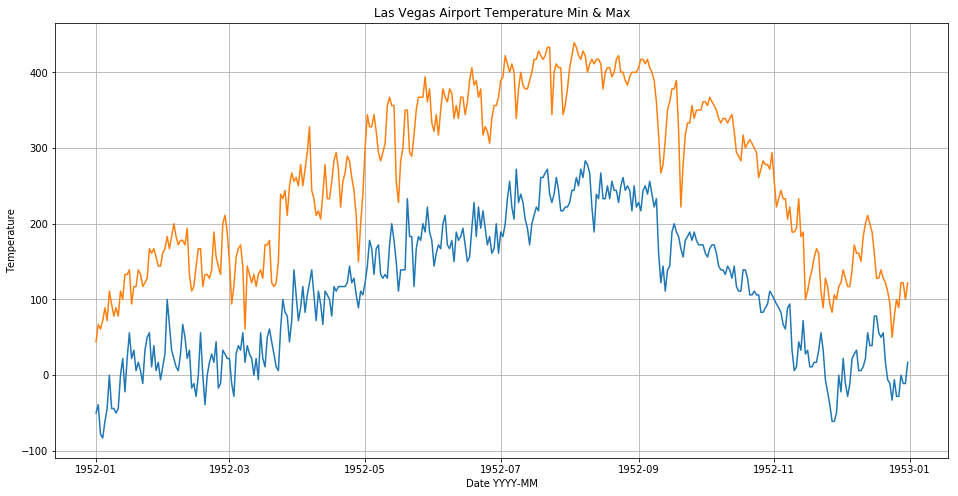

In [42]:
# Plot the data
plt.figure(figsize=(16,8))
plt.plot(vegas_day, vegas_tmin, label = "Min Temp")
plt.plot(vegas_day, vegas_tmax, label = "Max Temp")
plt.xlabel('Date YYYY-MM')
plt.ylabel('Temperature')
plt.title('Las Vegas Airport Temperature Min & Max')
plt.grid(True)
plt.savefig("vegas.png")
plt.show()

### Save the plot in our Jupyter environment

For these Globus Transfer API interactions, we use the transfer token. As the Globus Transfer API does not support __[`application/x-www-form-urlencoded`](https://docs.globus.org/api/transfer/overview/#document_formats)__ data, we are explicit about the JSON we pass.

At this point, we'll:

1. Activate the endpoint we're using for the tutorial
1. Create a directory for our file
1. `PUT` our plot there
1. Generate a link to our plot and view it

Note, the calls to Transfer can be made via the Globus SDK, with argument validation, etc. For this tutorial we're sticking with direct HTTP request for pedagogical purposes.

In [36]:
# Base URL for the Globus Transfer API
base_url = 'https://transfer.api.globus.org/v0.10'
# ID of the endpoint that we're using for the tutorial
endpoint_uuid = 'e56c36e4-1063-11e6-a747-22000bf2d559'

# Create the header
headers = {'Authorization':'Bearer '+ tokens['tokens']['transfer.api.globus.org']['access_token'],
          "Content-Type" : "application/json"}

In [37]:
# Grab our username (which includes a hash to avoid collision)
username = os.getenv('JUPYTERHUB_USER')
print("My user name is " + username)

My user name is ianmfswcnbrmu3tillegi3tiljrgfs


In [38]:
# Autoactivate the endpoint
resp = requests.post(base_url + '/endpoint/' + endpoint_uuid + '/autoactivate',
                    headers=headers)
print(resp.status_code)
print(resp.text)

200
{
  "DATA": [], 
  "DATA_TYPE": "activation_result", 
  "code": "AutoActivated.GlobusOnlineCredential", 
  "endpoint": "petrel#testbed", 
  "expire_time": "2018-08-21 19:52:00+00:00", 
  "expires_in": -1, 
  "length": 0, 
  "message": "Endpoint activated successfully using Globus Online credentials.", 
  "oauth_server": null, 
  "request_id": "CalSDy8Hw", 
  "resource": "/endpoint/e56c36e4-1063-11e6-a747-22000bf2d559/autoactivate", 
  "subject": "/C=US/O=Globus Consortium/OU=Globus Connect User/CN=ian"
}


In [39]:
# Call the Transfer API to make the directory
# Note, this will throw a 502 if the directory already exists.
# So don't panic if that happens when you rerun it.
# Later this can be done directly via Collections
mkdir_payload = { "DATA_TYPE": "mkdir",
                  "path": "/test/jhtutorial/users/" + username }

resp = requests.post(base_url + '/endpoint/' + endpoint_uuid + '/mkdir',
                    headers=headers, json=mkdir_payload)
print(resp.status_code)
print(resp.text)

502
{
  "code": "ExternalError.MkdirFailed.Exists", 
  "message": "Path already exists, Error (mkdir)\nEndpoint: petrel#testbed (e56c36e4-1063-11e6-a747-22000bf2d559)\nServer: petreldtn1.pub.jlse.anl.gov:2811\nMessage: Path '/test/jhtutorial/users/ianmfswcnbrmu3tillegi3tiljrgfs' already exists\n", 
  "request_id": "w2R3g2gyI", 
  "resource": "/endpoint/e56c36e4-1063-11e6-a747-22000bf2d559/mkdir"
}


### 3) Put the plot on a shared endpoint on the Petrel data server at Argonne
This GCS endpoint supports HTTPS and we can `PUT` the plot image file there directly. (If it was larger or many files we might want to use a Transfer request.)

In [40]:
# Create the header
headers = {'Authorization':'Bearer '+ tokens['tokens']['petrel_https_server']['access_token']}

# Pass the file pointer reference to the requests library for the PUT
image_data = open('vegas.png', 'rb')

# Get the user info as JSON
resp = requests.put('https://testbed.petrel.host/test/jhtutorial/users/' + username + '/vegas.png',
                    headers=headers, data=image_data, allow_redirects=False)
print(resp.status_code)

200


### 4) Share a link to the plot file

Let's look at a link to the file. This will require you to authenticate to the GCS endpoint since your browser is a different client than this notebook server.

In [41]:
print('https://testbed.petrel.host/test/jhtutorial/users/' + username + '/vegas.png')

https://testbed.petrel.host/test/jhtutorial/users/ianmfswcnbrmu3tillegi3tiljrgfs/vegas.png


We can also look at the folders and permissions on the __[shared endpoint](https://www.globus.org/app/transfer?origin_id=e56c36e4-1063-11e6-a747-22000bf2d559&origin_path=%2Ftest%2Fjhtutorial%2F)__